# Setup

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import math
from tensorflow.keras import layers, models, metrics, optimizers, Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from pandas import DataFrame
import seaborn as sn

try:
    from livelossplot import PlotLossesKeras
except ImportError:
    ! pip install -q -U livelossplot
    from livelossplot import PlotLossesKeras

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

try:
  import keras_tuner as kt
except ImportError:
  ! pip install -q -U keras-tuner
  import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
def plot_conf_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels) # rows=true, cols=pred
    sum_true = tf.expand_dims(tf.reduce_sum(cm, axis=1), axis=1) # sum per row (total # true)
    norm_cm = (cm / sum_true).numpy()

    df = DataFrame(norm_cm, index=ALL_LABELS, columns=ALL_LABELS)
    # df[df == 0] = np.nan # to hide cell if value=0

    fig, ax = plt.subplots(figsize=(5,5))
    heatmap = sn.heatmap(df, cmap='Blues', cbar=False, square=True, annot=True, fmt='.1%', ax=ax, linewidths=.2, linecolor=[0,.1,.2])
    ax.tick_params(left=False, bottom=False)
    plt.xlabel("Predicted y")
    plt.ylabel("True y")
    plt.show()

# Dataset

In [ ]:
"""
Each class is represented by a number
0	: airplane
1	: automobile
2	: bird
3	: cat
4	: deer
5	: dog
6	: frog
7	: horse
8	: ship
9	: truck
"""
NUM_LABELS = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.reshape((50000,))
y_test = y_test.reshape((10000,))
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)

x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

170498071/170498071 [==============================] - 31s 0us/step


In [ ]:
ALL_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels_dict = {i:ALL_LABELS[i] for i in range(10)}

# Model

## Creation

In [ ]:
hp = {
    'dense1_len': 65,
    'dense2_len': 77,
    'learning_rate': 1e-4,

    'dropout_rate': 0.33 ,

    'conv1_nfilters': 67,
    'conv1_kernel_size': 3,
    'conv1_strides': 1,

    'maxpool1_width': 2,
    'maxpool1_stride': 2,

    'conv2_nfilters': 12,
    'conv2_kernel_size': 4,
    'conv2_strides': 1,

    'maxpool2_width': 2,
    'maxpool2_stride': 2,

    'conv3_nfilters': 23,
    'conv3_kernel_size': 4,
    'conv3_strides': 1,

    'maxpool3_width': 2,
    'maxpool3_stride': 2,
}

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in_x (InputLayer)           [(None, 32, 32, 3)]       0         
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 12)        588       
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 12)       48        
 hNormalization)                                                 
                                                                 
 dropout2 (Dropout)          (None, 32, 32, 12)        0         
                                                                 
 maxpool2 (MaxPooling2D)     (None, 16, 16, 12)        0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                             

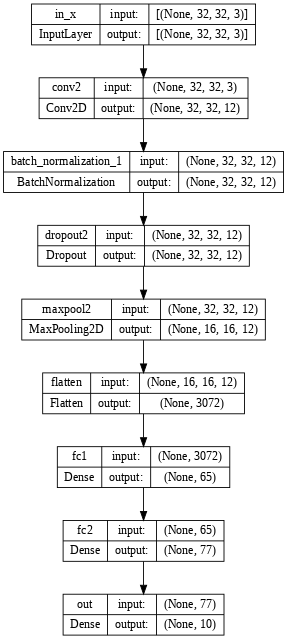

In [ ]:
def get_model(x_shape, hp):
    x = Input(name='in_x', shape=x_shape)

    '''
    Conv blocks
    '''

    conv = layers.Conv2D(filters=hp['conv1_nfilters'], kernel_size=hp['conv1_kernel_size'], strides=hp['conv1_strides'],
                         name='conv1', activation='relu', kernel_regularizer='l2', padding='same')(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Dropout(name='dropout1', rate=hp['dropout_rate'])(conv)
    conv = layers.MaxPooling2D(name='maxpool1', pool_size=hp['maxpool1_width'], strides=hp['maxpool1_stride'])(conv)


    conv = layers.Conv2D(filters=hp['conv2_nfilters'], kernel_size=hp['conv2_kernel_size'], strides=hp['conv2_strides'],
                         name='conv2', activation='relu', kernel_regularizer='l2', padding='same')(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Dropout(name='dropout2', rate=hp['dropout_rate'])(conv)
    conv = layers.MaxPooling2D(name='maxpool2', pool_size=hp['maxpool2_width'], strides=hp['maxpool2_stride'])(conv)

    '''
    After adding the second block, make sure to complete the fully connected part below. It's similar
    to what we did yesterday. I've already flattened it for you.

    Now, train your model. See if it does well. Let me know once you've done this.

    After training with two blocks and talking to me, try adding a third "block" to improve performance.
    '''


    '''
    Fully connected
    '''
    flatten = layers.Flatten(name='flatten')(conv)
    fc = layers.Dense(name='fc1', units=hp['dense1_len'], activation='relu', kernel_regularizer='l2')(flatten)
    fc = layers.Dense(name='fc2', units=hp['dense2_len'], activation='relu', kernel_regularizer='l2')(fc)

    out = layers.Dense(name='out', activation='softmax', units=NUM_LABELS)(fc)



    # compiling the model...
    model = Model(name="model", inputs=x, outputs=out)
    model.compile(
                optimizer=optimizers.Adam(learning_rate=hp['learning_rate'], clipnorm=1.0), # clipnorm=1.0 does gradient clipping to stop gradient explosion
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

model = get_model(x_train_norm[0].shape, hp)
model.summary()
plot_model(model, show_shapes=True, dpi=64)

## Training

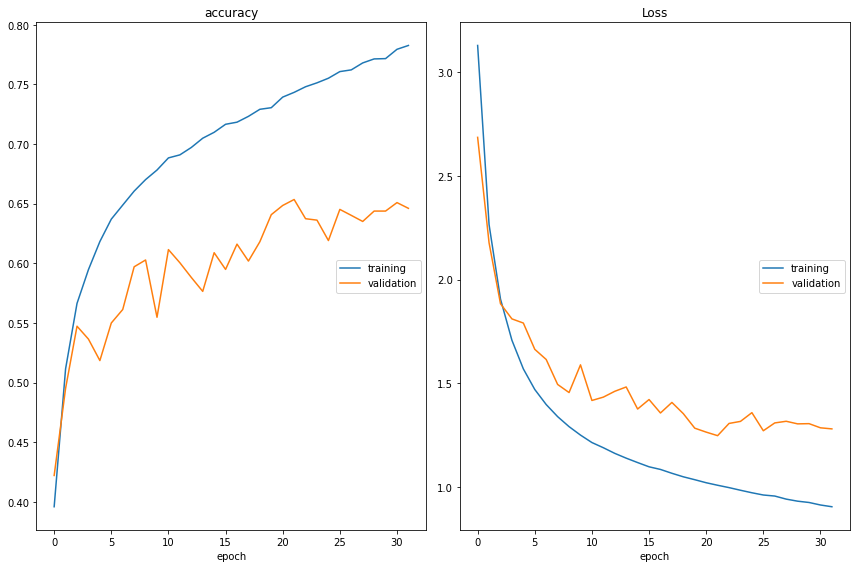

accuracy
	training         	 (min:    0.396, max:    0.783, cur:    0.783)
	validation       	 (min:    0.422, max:    0.654, cur:    0.646)
Loss
	training         	 (min:    0.905, max:    3.128, cur:    0.905)
	validation       	 (min:    1.248, max:    2.685, cur:    1.280)
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9051 - accuracy: 0.7826 - val_loss: 1.2803 - val_accuracy: 0.6461


In [ ]:
tf.random.set_seed(42)
model = get_model(x_train_norm[0].shape, hp)
history = model.fit(x_train_norm, tf.one_hot(y_train, depth=NUM_LABELS),
                        epochs=40,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                                   PlotLossesKeras()],
                        validation_data=(x_test_norm, tf.one_hot(y_test, depth=NUM_LABELS))
                    )

# Results

## Training Performance

In [2]:
y_train_probs = model.predict(x_train_norm)
model_train_pred = [np.argmax(y) for y in y_train_probs]

NameError: ignored

In [ ]:
print("Training Performance")
print("Accuracy", accuracy_score(y_train, model_train_pred))
print("F1 Score (macro)", f1_score(y_train, model_train_pred, average='macro'))
plot_conf_matrix(y_train, model_train_pred)

## Test Performance

In [ ]:
y_test_probs = model.predict(x_test_norm)
model_test_pred = [np.argmax(y) for y in y_test_probs]

print("Test Performance")
print("Accuracy", accuracy_score(y_test, model_test_pred))
print("F1 Score (macro)", f1_score(y_test, model_test_pred, average='macro'))
plot_conf_matrix(y_test, model_test_pred)

In [ ]:
for i in range(10):
    print(f'TEST IMAGE {i}')
    print('Predicted:', labels_dict[model_test_pred[i]])
    print('Actual:', labels_dict[y_test[i]])
    print('Image:')
    plt.imshow(x_test[i], cmap='gray')
    plt.show()